# Sampling into the future with Delphi

Welcome to the Delphi sampling notebook!

Delphi is a generative autoregressive model that not only predicts the future disease rates, but also sample entire disease trajectories one step at a time.

In this notebook, we will sample trajectories from Delphi and reproduce some of the figures from the paper. Note that this notebook in its current state was executed using the original Delphi checkpoint and full UK biobank data. The small synthetic dataset we provide in this repository may not be sufficient to reproduce all the results.

Let's start by revising some statistical theory that will help us understand the sampling process.

This notebook requires up to an hour to run with a GPU - it is not recommended to run it on a CPU.


### Delphi: Disease Trajectory Prediction with Competing Exponentials

Delphi is an autoregressive transformer model that predicts both **what** medical events will occur and **when** they will happen. It uses competing exponential distributions to model waiting times between events.

**Model Framework**
- For each possible medical event $i$, Delphi outputs logits $l_i$ representing log-rates
- The rate of each event is $\lambda_i = e^{l_i}$
- The probability of event $i$ occurring next is given by softmax:
$$P(i) = \frac{\lambda_i}{\sum_j \lambda_j} = \frac{e^{l_i}}{\sum_j e^{l_j}}$$

**Time Prediction**
- Each event has waiting time $T_i \sim \text{Exp}(\lambda_i)$
- The time until next event is $T^* = \min_i(T_i)$
- $T^*$ follows exponential distribution with rate $\sum_i \lambda_i$
- Expected waiting time: $$E[T^*] = \frac{1}{\sum_i \lambda_i}$$
- This all are just properties of exponential distributions

**Sampling Process**
1. Get logits $l_i$ from transformer
2. Sample next event: $i \sim \text{Softmax}(l)$
3. Sample waiting time: $T^* \sim \text{Exp}(\sum_i \lambda_i)$
4. Update trajectory with $(i, T^*)$
5. Repeat until terminal event or max age

For numerical stability, the sum of exponentials $\sum_i \lambda_i = \sum_i e^{l_i}$ can be computed using the logsumexp function: $\exp(\text{logsumexp}(l))$.

In [2]:
import os
import pickle
import torch
import torch.nn.functional
from model import DelphiConfig, Delphi
from tqdm import tqdm
import pandas as pd
import numpy as np
import textwrap

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'axes.grid': True,
                     'grid.linestyle': ':',
                     'axes.spines.bottom': False,
          'axes.spines.left': False,
          'axes.spines.right': False,
          'axes.spines.top': False})
plt.rcParams['figure.dpi'] = 72
plt.rcParams['pdf.fonttype'] = 42


delphi_labels = pd.read_csv('delphi_labels_chapters_colours_icd.csv')

## Load model

In [3]:
out_dir = 'Delphi-2M'
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype ='float32' #'bfloat16' # 'float32' or 'bfloat16' or 'float16'
seed = 1337

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device_type = 'cuda' if 'cuda' in device else 'cpu'
dtype = {'float32': torch.float32, 'float64': torch.float64, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

In [4]:
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)
conf = DelphiConfig(**checkpoint['model_args'])
model = Delphi(conf)
state_dict = checkpoint['model']
model.load_state_dict(state_dict)

model.eval()
model = model.to(device)
checkpoint['model_args']

number of parameters: 2.24M


{'n_layer': 12,
 'n_head': 12,
 'n_embd': 120,
 'block_size': 48,
 'bias': False,
 'vocab_size': 1270,
 'dropout': 0.0,
 'token_dropout': 0.0,
 't_min': 0.1,
 'mask_ties': True,
 'ignore_tokens': [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}

## Load data

In [5]:
from utils import get_batch, get_p2i

train = np.fromfile('data/ukb_simulated_data/train.bin', dtype=np.uint32).reshape(-1,3)
val = np.fromfile('data/ukb_simulated_data/val.bin', dtype=np.uint32).reshape(-1,3)

train_p2i = get_p2i(train) # mapping trajectory id to its position in the dataset
val_p2i = get_p2i(val)

## Conditional sampling

To estimate the quality of Delphi samples, we conduct the following experiment:

1. Take a cohort of individuals who have disease records both after and before age 60
2. Remove all records after age 60
3. Continue these shortened trajectories into the future using Delphi
4. Compare the continuation sampled by Delphi to the observed continuation

### Generating cohorts

In [6]:
d = get_batch(range(0,val_p2i.shape[0]-1,1), val, val_p2i,  
              select='left', block_size=63, 
              device=device, padding='random')

In [7]:
# prepare the shortened trajectories

age = 60
n_samples = len(d[0])

w = np.where((d[1].cpu().detach().numpy() <= age * 365.25).any(1) * (d[3].cpu().detach().numpy() >= age * 365.25).any(1))
u = np.unique(w[0])

d0 = d[0][u[:n_samples]].clone().detach()
d1 = d[1][u[:n_samples]].clone().detach()

d0[d1>age*365.25] = 0
d1[d1>age*365.25] = -10000.

if age > 0:
    d0 = torch.nn.functional.pad(d0, (0,1), 'constant', 1)
    d1 = torch.nn.functional.pad(d1, (0,1), 'constant', age*365.25)

o = d1.argsort(1)
d0 = d0.gather(1, o)
d1 = d1.gather(1, o)
d0.shape

torch.Size([63671, 64])

In [8]:
def aggregate(x, t, start, end):
    t = t.clamp(start, end)
    use = ((t >= start) * (t<end))+0.
    dt = t.diff(1)
    return torch.einsum("ijk,ij->ik", (x.nan_to_num() * use[:,:-1,None]), dt)

In [9]:
batch_size = 128
n_repeats = 1 # one good make the estimates calculated from synthetic data less noisy by averaging over multiple resamples
oo = []
inc = []
model.to(device)
for _ in range(n_repeats):
    with torch.no_grad():
        for dd in tqdm(zip(*map(lambda x: torch.split(x, batch_size), (d0,d1))), total=len(d0)//batch_size + 1):
            mm = model.generate(dd[0].to(device), dd[1].to(device), max_age=80*365.25, 
                                no_repeat=True, max_new_tokens=128, termination_tokens=[1269])
            oo += [(mm[0],mm[1])]
            inc += [torch.stack([aggregate(mm[2][:,:-1].exp(), mm[1].nan_to_num(80 * 365.25), a * 365.25, (a+1)* 365.25)/\
                                aggregate(~mm[2][:,:-1].isnan(), mm[1].nan_to_num(80 * 365.25), a * 365.25, (a+1)* 365.25) for a in range(40, 80)], dim=2).cpu()]

  0%|                                                                                                                                                                                                                  | 0/498 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 498/498 [15:32<00:00,  1.87s/it]


In [10]:
max_len = max(x[1].shape[1] for x in oo)

a = [np.pad(x[0].cpu(), ((0,0), (0, max_len - x[0].shape[1])), constant_values=0) for x in oo]
b = [np.pad(x[1].cpu(), ((0,0), (0, max_len - x[1].shape[1])), constant_values=-10000) for x in oo]


# Concatenate along first dimension
a = np.concatenate(a, axis=0)
print(a.shape)
b = np.concatenate(b, axis=0) / 365.25
b = np.nan_to_num(b, nan=-27).astype('int')

syn_inc = np.zeros((len(delphi_labels), 80))
for t in range(80):
    mask = (b == t)
    counts = np.bincount(a[mask], minlength=len(delphi_labels))
    syn_inc[:,t] += counts.astype('float')

# syn_inc /= (len(a) - syn_inc[-1].cumsum())
syn_inc /= (len(a) - np.histogram(b.max(1), np.arange(81))[0].cumsum())
inc = torch.vstack([i for i in inc]).transpose(1,2)
inc = 1-(-inc.exp()*365.25).exp()

(63671, 132)


In [11]:
a = d[2][u[:n_samples]].cpu().detach().numpy()
print(a.shape)
b = np.nan_to_num(d[3].cpu().detach().numpy().copy()[u[:n_samples]] / 365.25, nan=-27).astype('int')#[:,24:]

real_inc = np.zeros((len(delphi_labels), 80))
for t in range(80):
    mask = (b == t)
    counts = np.bincount(a[mask], minlength=len(delphi_labels))
    real_inc[:,t] = counts.astype('float')
real_inc /= (len(a) - np.histogram(b.max(1) + 1, np.arange(81))[0].cumsum())

(63671, 63)


# Real vs simulated disease rates

For autoregressive models, it is a common phehomenon when the model is imperfect and the "errors" are being accumulated and amplified as the model is run for more steps.

To validate if Delphi is resistant to this, we sample a set of trajectories from the age of 60 into the future, then compare the disease incidence at the age of 70-75.

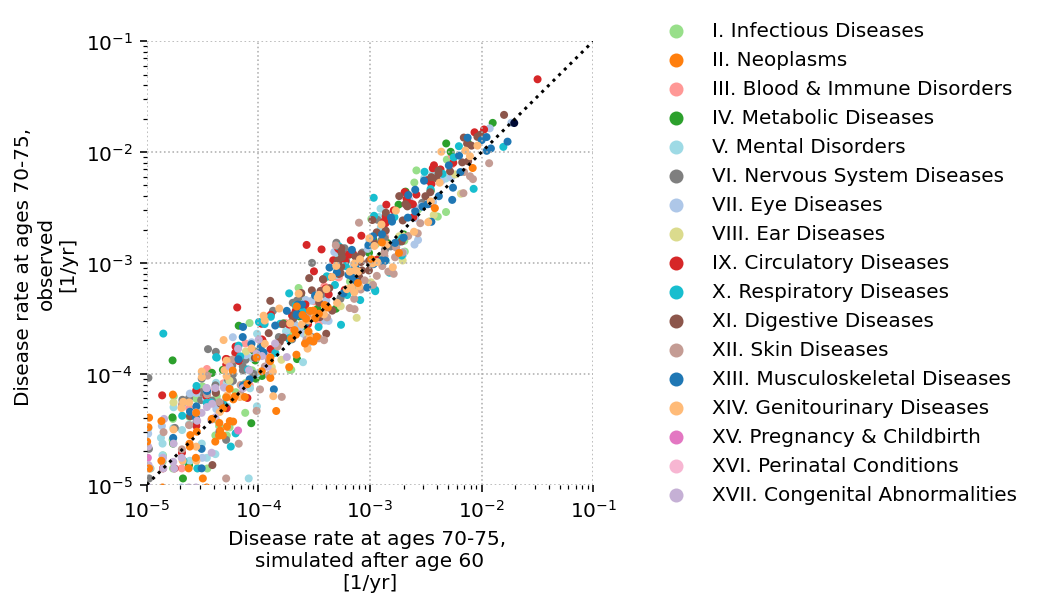

In [12]:
chapter_order = ['Technical', 'Sex', 'Smoking, Alcohol and BMI',
       'I. Infectious Diseases', 'II. Neoplasms', 'III. Blood & Immune Disorders',
       'IV. Metabolic Diseases', 'V. Mental Disorders',
       'VI. Nervous System Diseases', 'VII. Eye Diseases',
       'VIII. Ear Diseases', 'IX. Circulatory Diseases',
       'X. Respiratory Diseases', 'XI. Digestive Diseases',
       'XII. Skin Diseases', 'XIII. Musculoskeletal Diseases',
       'XIV. Genitourinary Diseases', 'XV. Pregnancy & Childbirth',
       'XVI. Perinatal Conditions', 'XVII. Congenital Abnormalities', 'Death']

ages_of_interest = [70, 71, 72, 73, 74]
plt.figure(figsize=(4,4))
plt.scatter(syn_inc[:,ages_of_interest].mean(-1), real_inc[:,ages_of_interest].mean(-1), marker=".", c=delphi_labels['color'])
plt.xlabel(f'Disease rate at ages {ages_of_interest[0]}-{ages_of_interest[-1]+1}, \nsimulated after age {age}\n[1/yr]')
plt.ylabel(f'Disease rate at ages {ages_of_interest[0]}-{ages_of_interest[-1]+1}, \nobserved\n[1/yr]')
plt.yscale('log')
plt.xscale('log')
plt.plot([0,1],[0,1], transform=plt.gca().transAxes, c='k', ls=":")
plt.xlim(1e-5,.1)
plt.ylim(1e-5,.1)

for chapter in chapter_order[3:-1]:
    color = delphi_labels[delphi_labels['ICD-10 Chapter (short)'] == chapter]['color'].values[0]
    plt.scatter([], [], c=color, label=chapter)

plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), frameon=False)
plt.show()

### Evaluating sampled vs observed disease incidence for different subgroups

We can also evaluate the model's performance for different subgroups.


#### Lifestyle

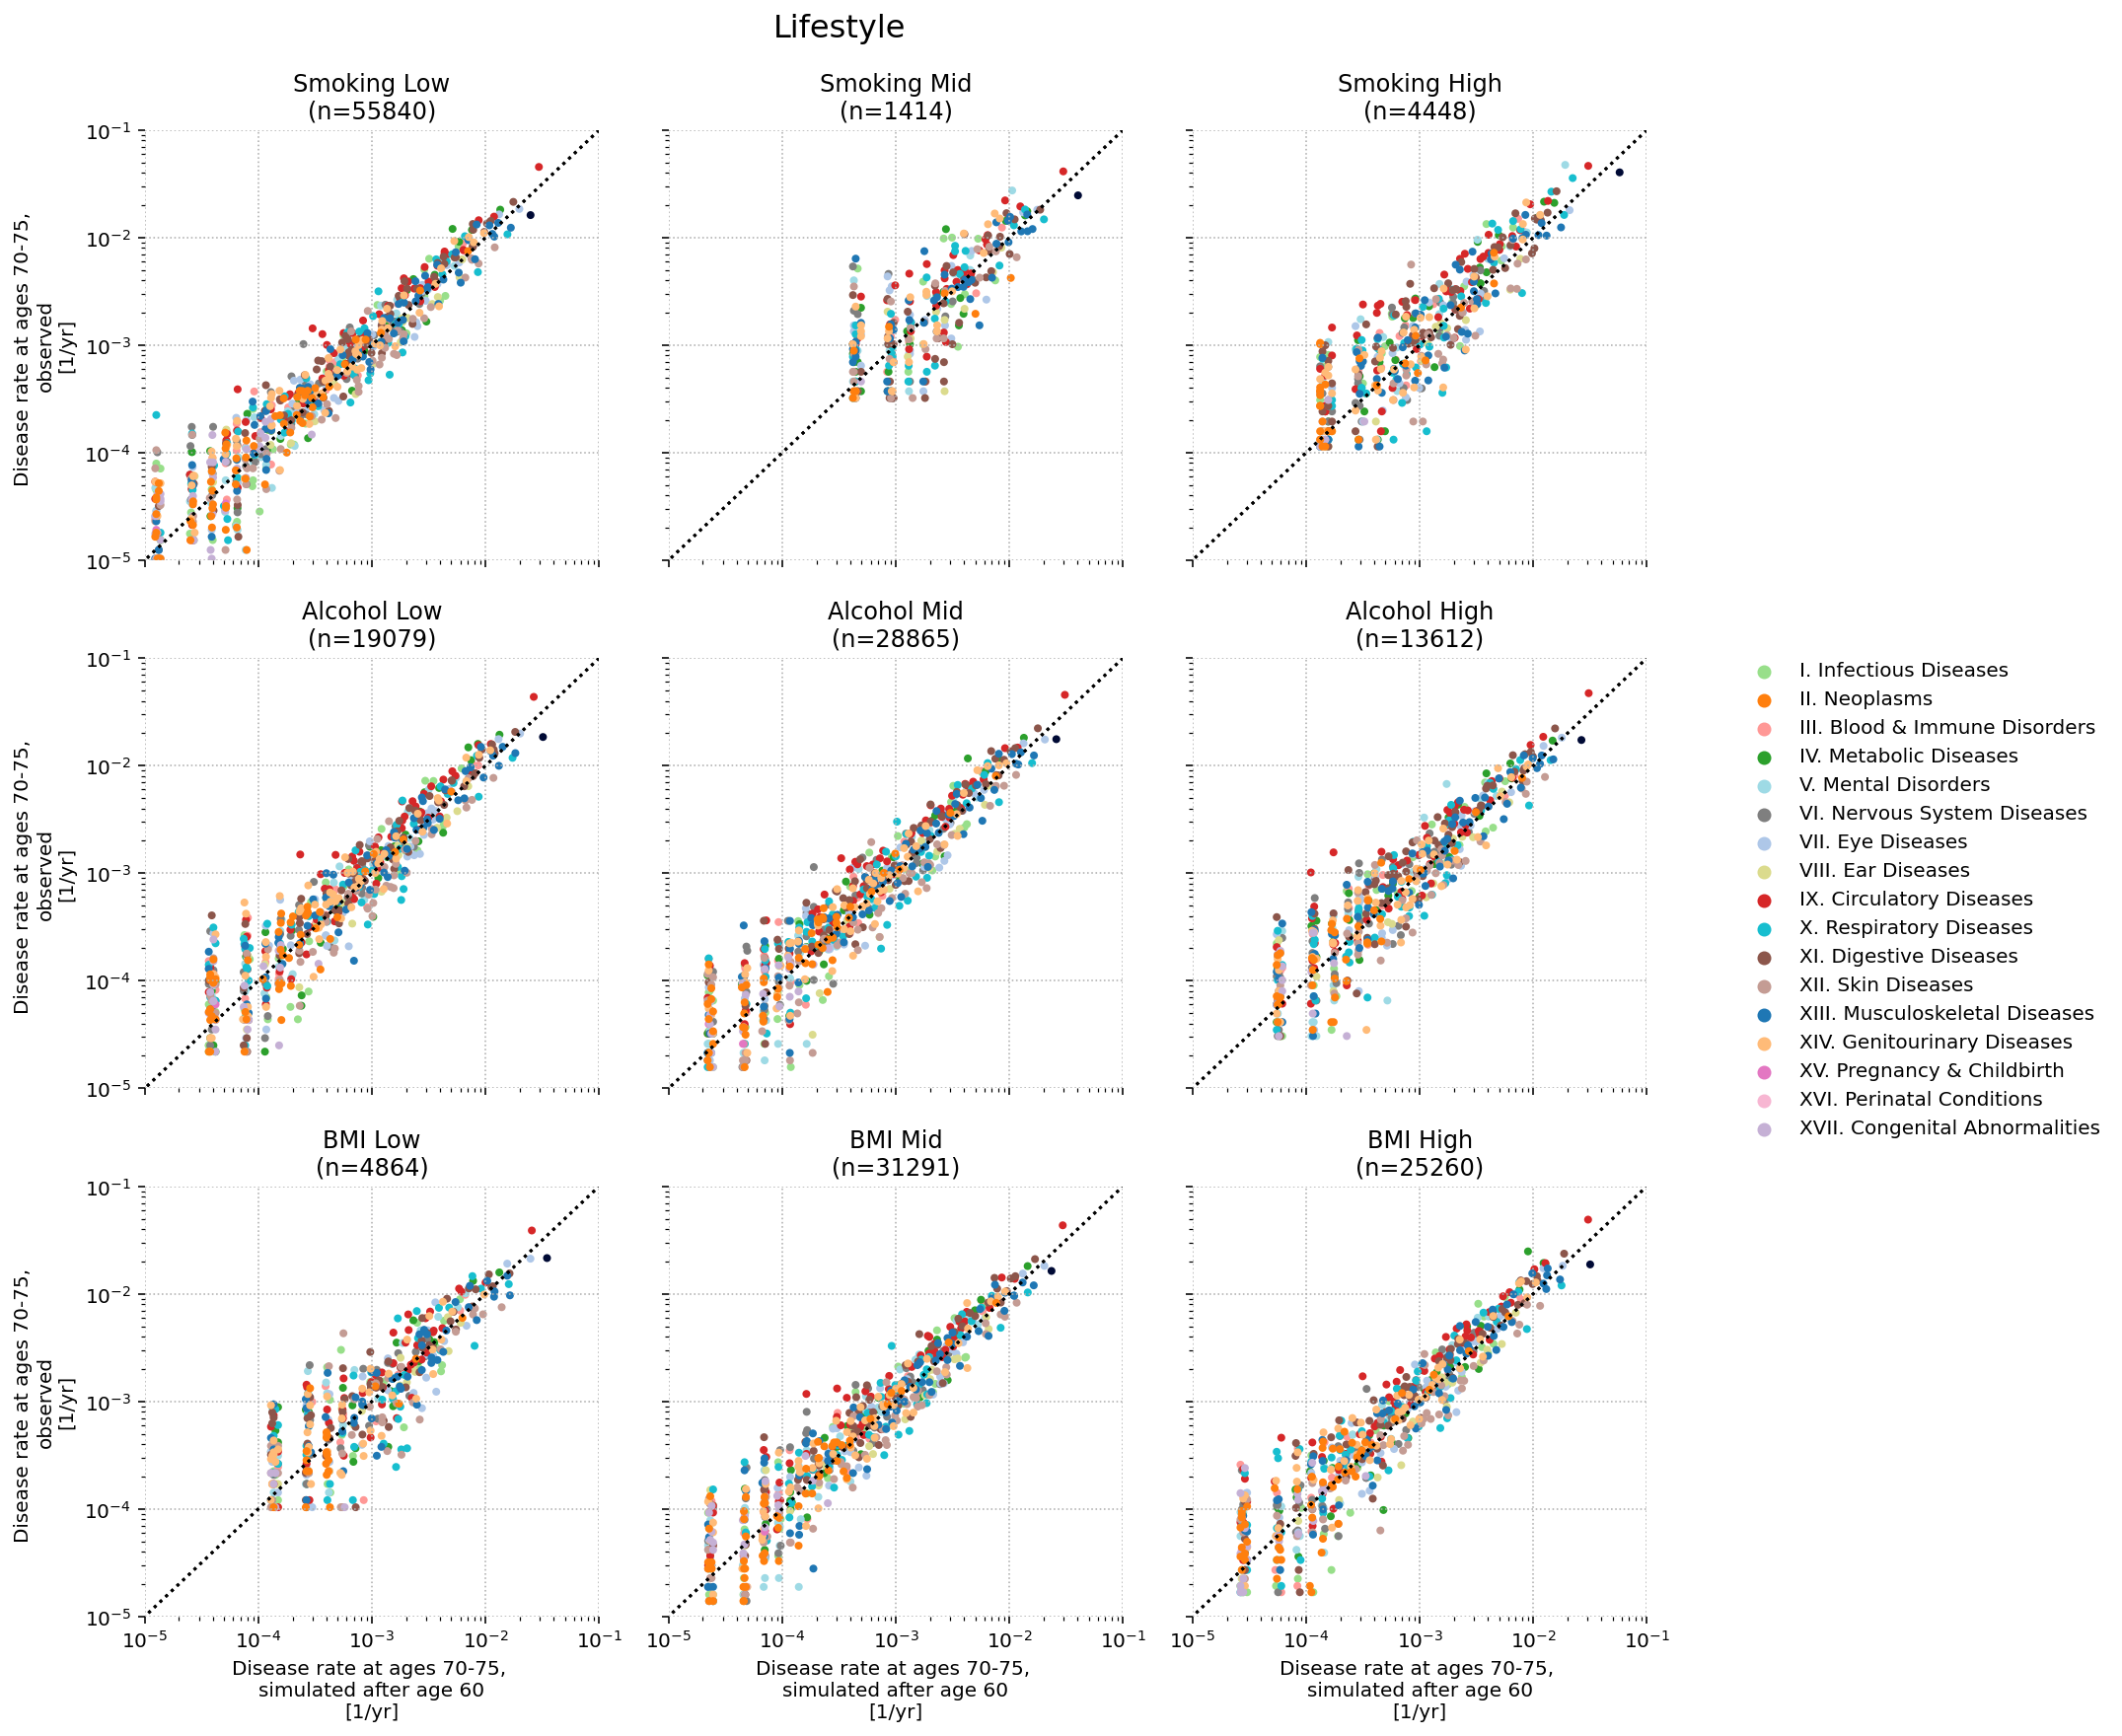

In [13]:
ages_of_interest = [70, 71, 72, 73, 74]

fig, axes = plt.subplots(3, 3, figsize=(12,12), sharex=True, sharey=True)
titles = [['Smoking Low', 'Smoking Mid', 'Smoking High'],
          ['Alcohol Low', 'Alcohol Mid', 'Alcohol High'], 
          ['BMI Low', 'BMI Mid', 'BMI High']]

tokens = [[7, 8, 9],
          [10, 11, 12],
          [4, 5, 6]]

all_syn_inc_lifestyle = np.zeros((9, len(delphi_labels)))
all_real_inc_lifestyle = np.zeros((9, len(delphi_labels)))

all_syn_inc_lifestyle_token_count = np.zeros((9, len(delphi_labels)))
all_real_inc_lifestyle_token_count = np.zeros((9, len(delphi_labels)))

all_syn_inc_lifestyle_count_all = np.zeros(9)
all_real_inc_lifestyle_count_all = np.zeros(9)

for i in range(3):
    for j in range(3):

        token_of_interest = tokens[i][j]

        # Get max length for padding
        max_len = max(x[1].shape[1] for x in oo)
        
        # Pad each array with nans and collect
        a = [np.pad(x[0].cpu(), ((0,0), (0, max_len - x[0].shape[1])), constant_values=0) for x in oo]
        b = [np.pad(x[1].cpu(), ((0,0), (0, max_len - x[1].shape[1])), constant_values=-10000) for x in oo]
        
        # Concatenate along first dimension
        a = np.concatenate(a, axis=0)
        b = np.concatenate(b, axis=0) / 365.25
        b = np.nan_to_num(b, nan=-27).astype('int')

        mask_syn = (a==token_of_interest).any(1)
        a = a[mask_syn]
        b = b[mask_syn]

        syn_inc = np.zeros((len(delphi_labels), 80))
        for t in range(80):
            mask = (b == t)
            counts = np.bincount(a[mask], minlength=len(delphi_labels))
            syn_inc[:,t] += counts.astype('float')

        mask_real = (d[0][u[:n_samples]]==token_of_interest).any(1).cpu().numpy()

        a = d[2][u[:n_samples]][mask_real].cpu().detach().numpy()#[:,24:]
        b = np.nan_to_num(d[3].cpu().detach().numpy().copy()[u[:n_samples]][mask_real] / 365.25, nan=-27).astype('int')#[:,24:]

        real_inc = np.zeros((len(delphi_labels), 80))
        for t in range(80):
            mask = (b == t)
            counts = np.bincount(a[mask], minlength=len(delphi_labels))
            real_inc[:,t] = counts.astype('float')

        
        all_real_inc_lifestyle_token_count[3*i+j] = real_inc[:,ages_of_interest].sum(-1)
        all_syn_inc_lifestyle_token_count[3*i+j] = syn_inc[:,ages_of_interest].sum(-1)

        all_syn_inc_lifestyle_count_all[3*i+j] = (mask_syn.sum() - syn_inc[-1].cumsum())[ages_of_interest].sum(-1)
        all_real_inc_lifestyle_count_all[3*i+j] = (mask_real.sum() - np.histogram(b.max(1) + 1, np.arange(81))[0].cumsum())[ages_of_interest].sum(-1)

        real_inc /= (mask_real.sum() - np.histogram(b.max(1) + 1, np.arange(81))[0].cumsum())
        syn_inc /= (mask_syn.sum() - syn_inc[-1].cumsum())

        all_syn_inc_lifestyle[3*i+j] = syn_inc[:,ages_of_interest].mean(-1)
        all_real_inc_lifestyle[3*i+j] = real_inc[:,ages_of_interest].mean(-1)

        ax = axes[i,j]

        ax.scatter(syn_inc[:,ages_of_interest].mean(-1), real_inc[:,ages_of_interest].mean(-1), marker=".", c=delphi_labels['color'])
        # ax.scatter(syn_inc[diseases_of_interest,age_of_interest], real_inc[diseases_of_interest,age_of_interest], marker=".", c=delphi_labels['color'].values[diseases_of_interest], edgecolors='k', zorder=10)

        ax.set_xlabel(f'Disease rate at ages {ages_of_interest[0]}-{ages_of_interest[-1]+1}, \nsimulated after age {age}\n[1/yr]')
        ax.set_ylabel(f'Disease rate at ages {ages_of_interest[0]}-{ages_of_interest[-1]+1}, \nobserved\n[1/yr]')
        ax.set_yscale('log')
        ax.set_xscale('log') 
        ax.plot([0,1],[0,1], c='k', ls=":")
        ax.plot([0, 10000], [0, 10000], c='k', ls=":")
        ax.set_xlim(1e-5,.1)
        ax.set_ylim(1e-5,.1)
        ax.set_title(titles[i][j] + f'\n(n={mask_real.sum()})')
        ax.label_outer()


# Add legend to the right of the entire figure
for chapter in chapter_order[3:-1]:
    color = delphi_labels[delphi_labels['ICD-10 Chapter (short)'] == chapter]['color'].values[0]
    axes[0,0].scatter([], [], c=color, label=chapter)

fig.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)
plt.tight_layout()
plt.suptitle('Lifestyle', y=1.02, size=16)
plt.show()

#### Prescence of certain diseases

We divide the trajectories into two groups: those that have a certain disease and those that do not.
Then we compare the disease incidence at the age of 70-75 between the two groups.

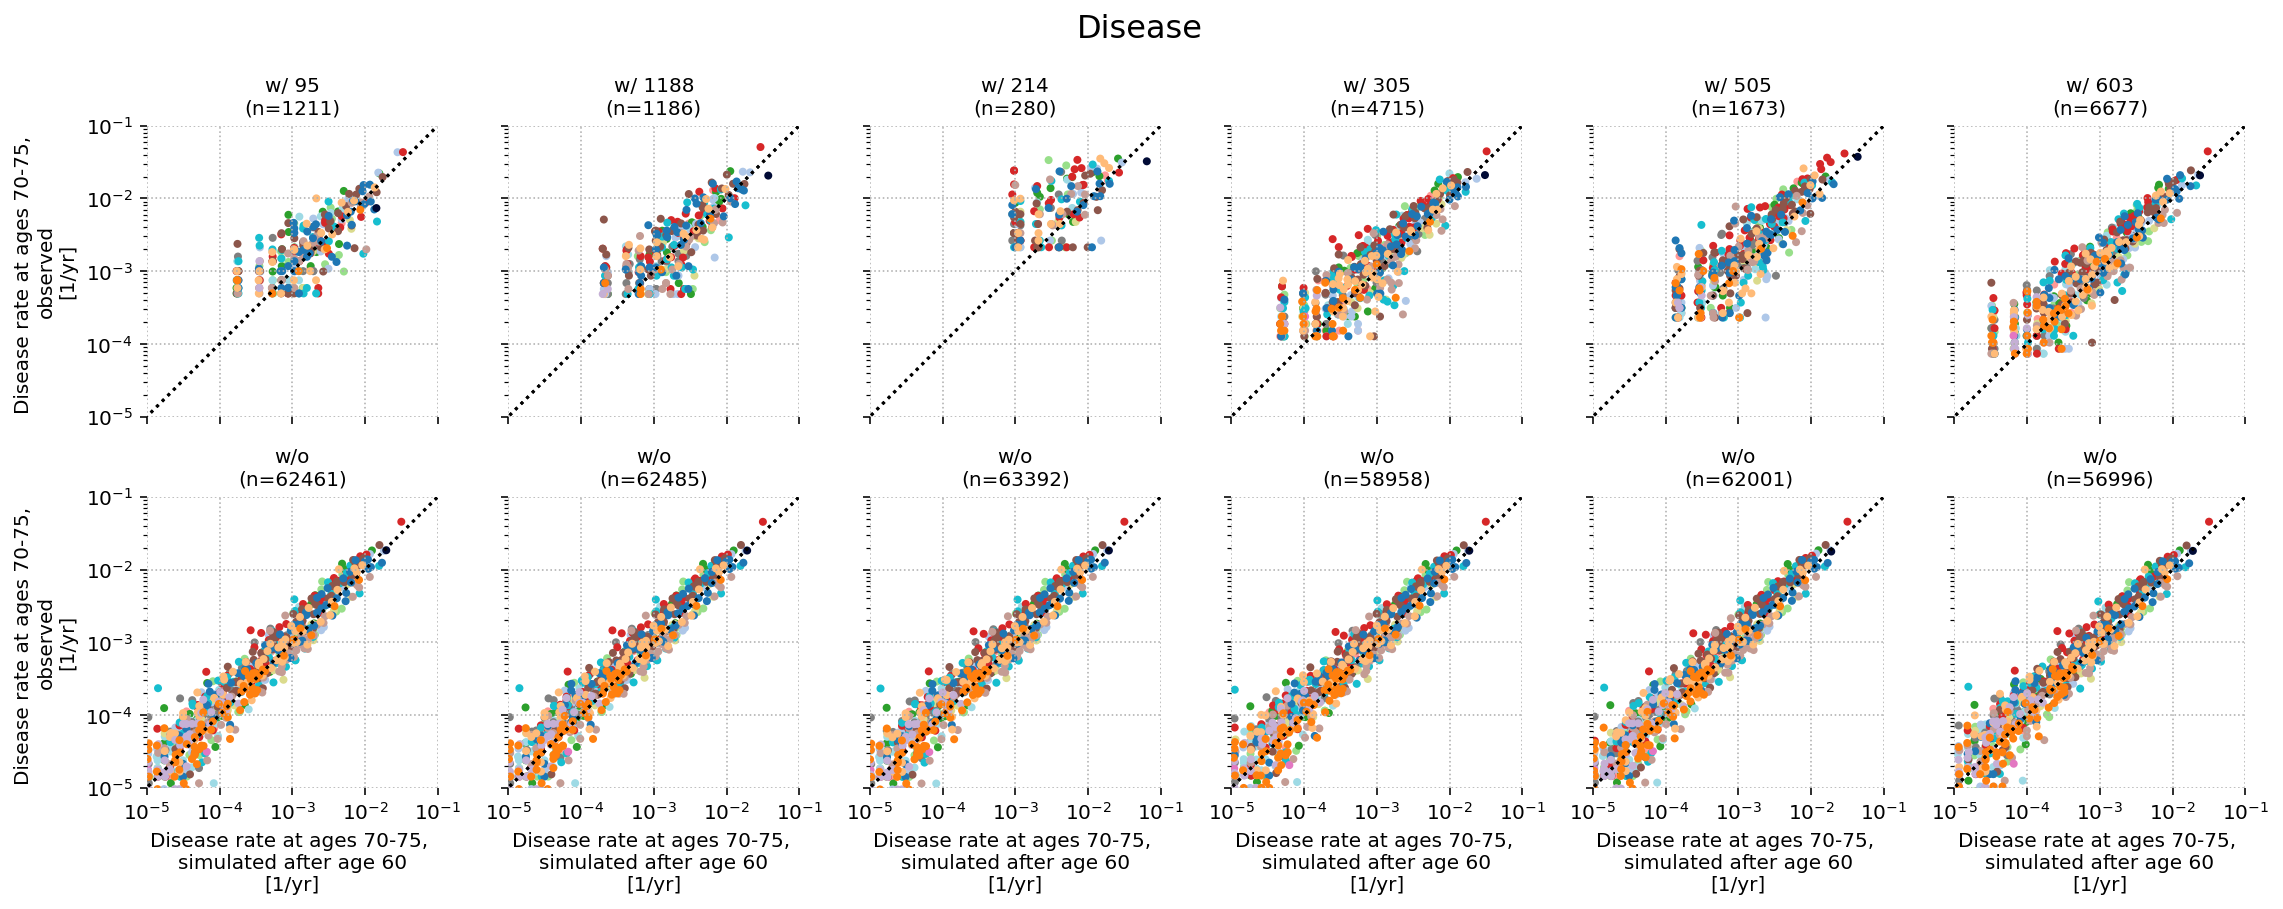

In [14]:
ages_of_interest = [70,71,72,73,74]

tokens = [95, 1188, 214, 305, 505, 603]
diseases_of_interest = [46, 95, 1168, 1188, 374, 214, 305, 505, 603, 1269]

fig, axes = plt.subplots(2, len(tokens), figsize=(16,6), sharex=True, sharey=True)

all_syn_inc_diseases = np.zeros((2 * len(diseases_of_interest), len(delphi_labels)))
all_real_inc_diseases = np.zeros((2 * len(diseases_of_interest), len(delphi_labels)))

all_syn_inc_diseases_token_count = np.zeros((2 * len(diseases_of_interest), len(delphi_labels)))
all_real_inc_diseases_token_count = np.zeros((2 * len(diseases_of_interest), len(delphi_labels)))

all_syn_inc_diseases_count_all = np.zeros(2 * len(diseases_of_interest))
all_real_inc_diseases_count_all = np.zeros(2 * len(diseases_of_interest))


for j in range(2):
    for i in range(len(tokens)):
        token_of_interest = tokens[i]
        title = f'{["w/", "w/o"][j]} {delphi_labels.iloc[token_of_interest].values[0]}'

        # Get max length for padding
        max_len = max(x[1].shape[1] for x in oo)
        
        # Pad each array with nans and collect
        a = [np.pad(x[0].cpu(), ((0,0), (0, max_len - x[0].shape[1])), constant_values=0) for x in oo]
        b = [np.pad(x[1].cpu(), ((0,0), (0, max_len - x[1].shape[1])), constant_values=-10000) for x in oo]
        
        # Concatenate along first dimension
        a = np.concatenate(a, axis=0)
        b = np.concatenate(b, axis=0) / 365.25
        b = np.nan_to_num(b, nan=-27).astype('int')

        if j == 0:
            mask_syn = ((a==token_of_interest) * (b < 60)).any(1)
        else:
            mask_syn = ~((a==token_of_interest) * (b < 60)).any(1)

        a = a[mask_syn]
        b = b[mask_syn]

        syn_inc = np.zeros((len(delphi_labels), 80))
        for t in range(80):
            mask = (b == t)
            counts = np.bincount(a[mask], minlength=len(delphi_labels))
            syn_inc[:,t] = counts.astype('float')


        a = d[2][u[:n_samples]].cpu().detach().numpy()#[:,24:]
        b = np.nan_to_num(d[3].cpu().detach().numpy().copy()[u[:n_samples]] / 365.25, nan=-27).astype('int')#[:,24:]

        if j == 0:
            mask_real = ((a==token_of_interest) * (b < 60)).any(1)
        else:
            mask_real = ~((a==token_of_interest) * (b < 60)).any(1)

        a = a[mask_real]
        b = b[mask_real]

        real_inc = np.zeros((len(delphi_labels), 80))
        for t in range(80):
            mask = (b == t)
            counts = np.bincount(a[mask], minlength=len(delphi_labels))
            real_inc[:,t] = counts.astype('float') 
        all_real_inc_diseases_token_count[j*len(tokens)+i] = real_inc[:,ages_of_interest].sum(-1)
        all_syn_inc_diseases_token_count[j*len(tokens)+i] = syn_inc[:,ages_of_interest].sum(-1)

        all_syn_inc_diseases_count_all[j*len(tokens)+i] = (mask_syn.sum() - syn_inc[-1].cumsum())[ages_of_interest].sum()
        all_real_inc_diseases_count_all[j*len(tokens)+i] = (mask_real.sum() - np.histogram(b.max(1) + 1, np.arange(81))[0].cumsum())[ages_of_interest].sum()

        real_inc /= (mask_real.sum() - np.histogram(b.max(1) + 1, np.arange(81))[0].cumsum())
        syn_inc /= (mask_syn.sum() - syn_inc[-1].cumsum())  

        all_syn_inc_diseases[j*len(tokens)+i] = syn_inc[:,ages_of_interest].mean(-1)
        all_real_inc_diseases[j*len(tokens)+i] = real_inc[:,ages_of_interest].mean(-1)

        ax = axes[j][i]
        ax.scatter(syn_inc[:,ages_of_interest].mean(-1), real_inc[:,ages_of_interest].mean(-1), marker=".", c=delphi_labels['color'])

        ax.set_xlabel(f'Disease rate at ages {ages_of_interest[0]}-{ages_of_interest[-1]+1}, \nsimulated after age {age}\n[1/yr]')
        ax.set_ylabel(f'Disease rate at ages {ages_of_interest[0]}-{ages_of_interest[-1]+1}, \nobserved\n[1/yr]')
        ax.set_yscale('log')
        ax.set_xscale('log') 
        ax.plot([0,1],[0,1], c='k', ls=":")
        ax.plot([0, 10000], [0, 10000], c='k', ls=":")
        ax.set_xlim(1e-5,.1)
        ax.set_ylim(1e-5,.1)
        ax.set_xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
        if j == 0:
            ax.set_title(textwrap.fill(title, 30) + f'\n(n={mask_syn.sum()})', fontsize=10)
        else:
            ax.set_title('w/o' + f'\n(n={mask_real.sum()})', fontsize=10)
        
        ax.label_outer()
        ax.set_aspect('equal')


# Add legend to the right of the entire figure
for chapter in chapter_order[3:-1]:
    color = delphi_labels[delphi_labels['ICD-10 Chapter (short)'] == chapter]['color'].values[0]
    axes[0][0].scatter([], [], c=color, label=chapter)

# fig.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)
plt.tight_layout()
plt.suptitle('Disease', y=1.05, size=16)
plt.show()

## Real vs simulated disease rate fold change between subcohorts

Most interestingly, we can evaluate if the model is able to capture the influence of lifestyle or presence of certain diseases on the disease incidence.

To do this, we use previously computed synthetic and observed disease incidence for different subgroups and calculate the fold change between them. Then we can compare the fold changes between subgroups when canculated from sampled and observed data.

In [15]:
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))


def plot_fold_change_comparison(fold_change_syn, fold_change_real, fold_change_syn_sd, fold_change_real_sd, 
                              labels, delphi_labels, title_prefix, xlabel_prefix, n_plots=4, figsize=(14,3), corr_mask=None):
    """Plot comparison of fold changes between synthetic and real data.
    
    Args:
        fold_change_syn: List of synthetic fold changes for each comparison
        fold_change_real: List of real fold changes for each comparison  
        fold_change_syn_sd: List of synthetic fold change standard deviations
        fold_change_real_sd: List of real fold change standard deviations
        labels: List of labels for each comparison plot
        delphi_labels: DataFrame with color and count info for points
        title_prefix: String prefix for plot titles
        xlabel_prefix: String prefix for x-axis labels
        n_plots: Number of comparison plots to create
    """
    fig, axes = plt.subplots(1, n_plots, figsize=figsize, sharex=True, sharey=True)

    for i in range(n_plots):
        non_nan = ~np.isnan(fold_change_syn[i]) * ~np.isnan(fold_change_real[i]) * ~np.isinf(fold_change_syn[i]) * \
            ~np.isinf(fold_change_real[i]) * (fold_change_syn[i] > 0) * (fold_change_real[i] > 0) * (np.arange(len(fold_change_real[i])) > 13)
        
        corr_weights = (1/fold_change_syn_sd[i])**2
        corr_weights = corr_weights / corr_weights[non_nan].sum()
        r_weighted = corr(np.log10(fold_change_syn[i][non_nan]), np.log10(fold_change_real[i][non_nan]), corr_weights[non_nan])
        r = np.corrcoef(np.log10(fold_change_syn[i][non_nan]), np.log10(fold_change_real[i][non_nan]))[0,1]

        ax = axes[i]
        for j in range(len(fold_change_syn[i])):
            if non_nan[j]:
                xerr = fold_change_syn[i][j] - np.exp(np.log(fold_change_syn[i][j]) + np.array([-1,1]) * 2 * fold_change_syn_sd[i][j])
                yerr = fold_change_real[i][j] - np.exp(np.log(fold_change_real[i][j]) + np.array([-1,1]) * 2 * fold_change_real_sd[i][j])
                # ax.errorbar(fold_change_syn[i][j], fold_change_real[i][j],
                #         xerr=np.abs(xerr)[:, None], yerr=np.abs(yerr)[:, None],
                #         fmt='none', c=(0.8, 0.8, 0.8), lw=0.5, alpha=1, zorder=-3)
        sizes = delphi_labels['count'].values[non_nan] / 250
        ax.scatter(fold_change_syn[i][non_nan], fold_change_real[i][non_nan],
                   marker=".", c=delphi_labels['color'][non_nan], s=sizes)
    
        
        # plot median
        # ax.scatter(np.median(fold_change_syn[i][non_nan]), np.median(fold_change_real[i][non_nan]), marker="x", c='k', zorder=10)

        ax.set_title(f'{labels[i]}, \nr={r:.2f},\nr_weighted={r_weighted:.2f}', fontsize=10)
        ax.set_xlabel(f'Fold change in modelled rate, {labels[i]}')
        # ax.set_ylabel(f'Fold change in observed rate, {labels[i]}')
        ax.set_xlabel(f'Fold change, modelled')
        if i == 0:
            ax.set_ylabel(f'Fold change, observed')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.plot([0.1,30],[0.1,30], c='k', ls=":")
        ax.set_xlim(0.1,30)
        ax.set_ylim(0.1,30)
        ax.set_aspect('equal')

    # add legend to the righttmost plot
    legend_sizes = [100, 1000, 10000]
    legend_elements = [plt.scatter([], [], c='gray', s=size/250, label=f'n={size}') 
                            for size in legend_sizes]
    ax.legend(handles=legend_elements, title='Sample size', 
                    loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

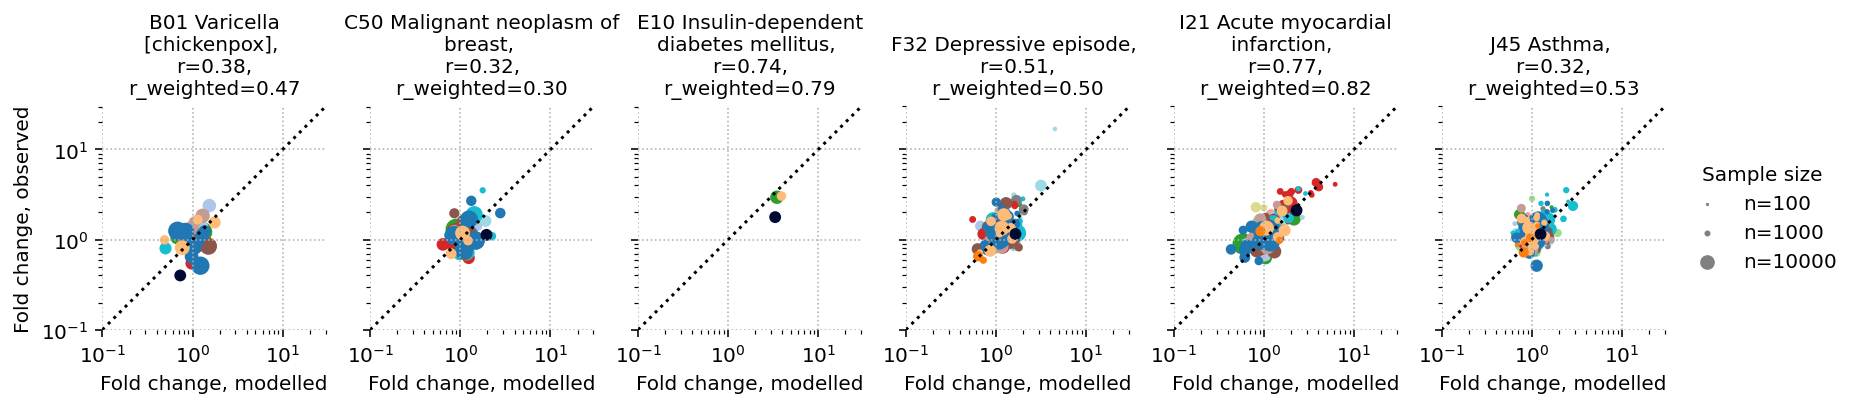

In [16]:

# Compare disease vs no disease fold changes for all 10 diseases
fold_change_real_disease = []
fold_change_syn_disease = []
fold_change_real_disease_sd = []
fold_change_syn_disease_sd = []
disease_comparisons = []


# Calculate fold changes for each disease vs no disease
for i in range(6):  # 10 diseases
    with np.errstate(divide='ignore', invalid='ignore'):
        fold_change_real_disease.append(all_real_inc_diseases[i] / all_real_inc_diseases[i+6])
        fold_change_syn_disease.append(all_syn_inc_diseases[i] / all_syn_inc_diseases[i+6])

        fold_change_real_disease[i][all_real_inc_diseases_token_count[i] < 10] = np.nan
        fold_change_syn_disease[i][all_syn_inc_diseases_token_count[i] < 10] = np.nan

        # Calculate standard deviations
        fold_change_real_disease_sd.append(
            np.sqrt(1/all_real_inc_diseases_token_count[i] + 1/all_real_inc_diseases_count_all[i] + 
                    1/all_real_inc_diseases_token_count[i+6] + 1/all_real_inc_diseases_count_all[i+6])
        )

        fold_change_syn_disease_sd.append(
            np.sqrt(1/all_syn_inc_diseases_token_count[i] + 1/all_syn_inc_diseases_count_all[i] + 
                    1/all_syn_inc_diseases_token_count[i+6] + 1/all_syn_inc_diseases_count_all[i+6])
        )
        
        disease_comparisons.append(textwrap.fill(delphi_labels.iloc[[95, 1188, 214, 305, 505, 603][i]]['name'], 25))

# Create comparison plots
plot_fold_change_comparison(
    fold_change_syn=fold_change_syn_disease,
    fold_change_real=fold_change_real_disease,
    fold_change_syn_sd=fold_change_syn_disease_sd,
    fold_change_real_sd=fold_change_real_disease_sd,
    labels=disease_comparisons,
    delphi_labels=delphi_labels,
    title_prefix='Disease',
    xlabel_prefix='Disease', 
    n_plots=6,
    figsize=(14,4)
)

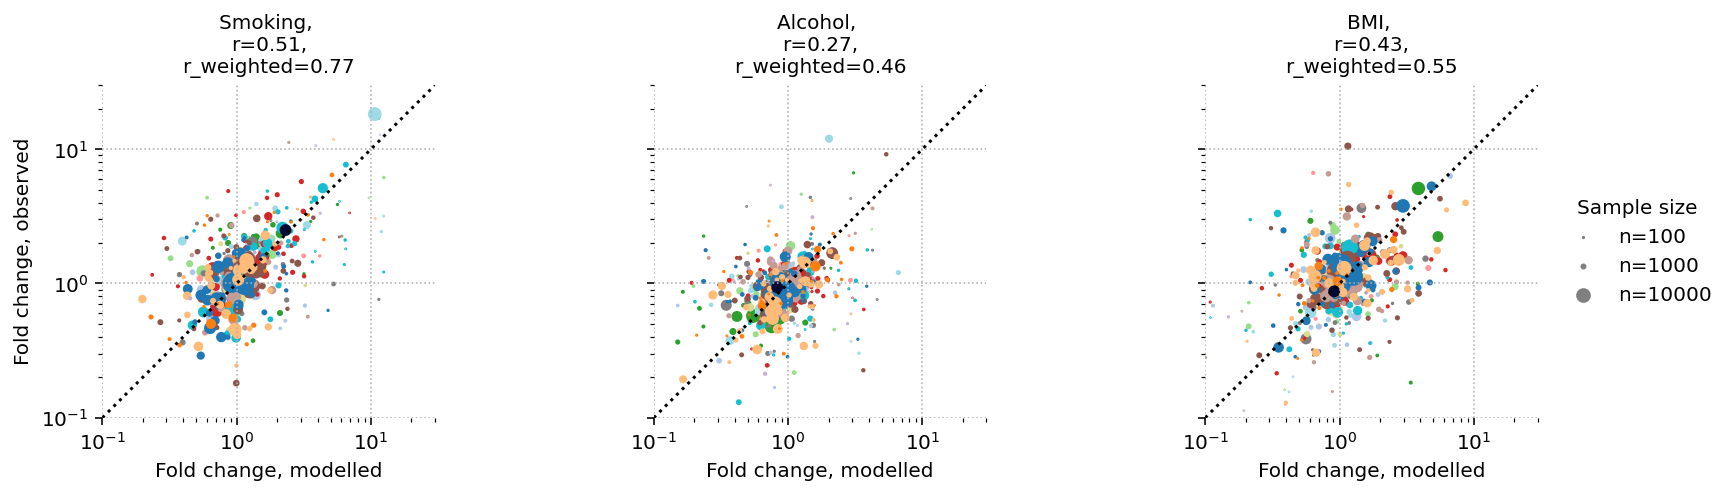

In [17]:
with np.errstate(divide='ignore', invalid='ignore'):
    fold_change_real_lifestyle = [all_real_inc_lifestyle[2] / all_real_inc_lifestyle[0], all_real_inc_lifestyle[5] / all_real_inc_lifestyle[3], all_real_inc_lifestyle[8] / all_real_inc_lifestyle[6]]
    fold_change_syn_lifestyle = [all_syn_inc_lifestyle[2] / all_syn_inc_lifestyle[0], all_syn_inc_lifestyle[5] / all_syn_inc_lifestyle[3], all_syn_inc_lifestyle[8] / all_syn_inc_lifestyle[6]]

    fold_change_real_lifestyle_sd = [
        np.sqrt(1/all_real_inc_lifestyle_token_count[2] + 1/all_real_inc_lifestyle_count_all[2] + 1/all_real_inc_lifestyle_token_count[0] + 1/all_real_inc_lifestyle_count_all[0]),
        np.sqrt(1/all_real_inc_lifestyle_token_count[5] + 1/all_real_inc_lifestyle_count_all[5] + 1/all_real_inc_lifestyle_token_count[3] + 1/all_real_inc_lifestyle_count_all[3]),
        np.sqrt(1/all_real_inc_lifestyle_token_count[8] + 1/all_real_inc_lifestyle_count_all[8] + 1/all_real_inc_lifestyle_token_count[6] + 1/all_real_inc_lifestyle_count_all[6])
    ]

    fold_change_syn_lifestyle_sd = [
        np.sqrt(1/all_syn_inc_lifestyle_token_count[2] + 1/all_syn_inc_lifestyle_count_all[2] + 1/all_syn_inc_lifestyle_token_count[0] + 1/all_syn_inc_lifestyle_count_all[0]),
        np.sqrt(1/all_syn_inc_lifestyle_token_count[5] + 1/all_syn_inc_lifestyle_count_all[5] + 1/all_syn_inc_lifestyle_token_count[3] + 1/all_syn_inc_lifestyle_count_all[3]),
        np.sqrt(1/all_syn_inc_lifestyle_token_count[8] + 1/all_syn_inc_lifestyle_count_all[8] + 1/all_syn_inc_lifestyle_token_count[6] + 1/all_syn_inc_lifestyle_count_all[6])
    ]

lifestyle = ['Smoking', 'Alcohol', 'BMI']

plot_fold_change_comparison(
    fold_change_syn=fold_change_syn_lifestyle,
    fold_change_real=fold_change_real_lifestyle,
    fold_change_syn_sd=fold_change_syn_lifestyle_sd,
    fold_change_real_sd=fold_change_real_lifestyle_sd,
    labels=lifestyle,
    delphi_labels=delphi_labels,
    title_prefix='Lifestyle',
    xlabel_prefix='Lifestyle',
    n_plots=3
)


Delphi successfuly reproduces the change in disease incidence between the groups, even when sampling from a long horizon.


### Real vs simulated disease rate time to next token

Text(0, 0.5, 'Time to next token')

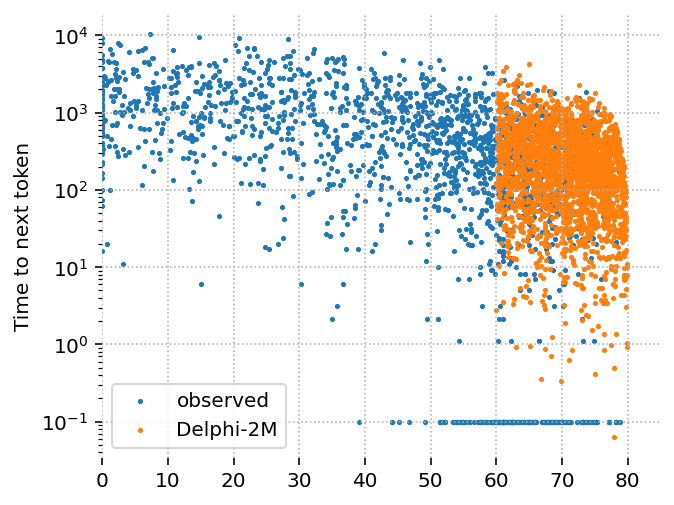

In [18]:
plt.figure(figsize=(5,4))

plt.scatter(d[1][u[:64]].cpu()[:,:-1].flatten()/365.25, .1+np.diff(d[1][u[:64]].cpu().detach(), axis=1).flatten(), marker='.', s=10, label='observed')

plt.scatter(oo[0][1].cpu()[:,64:-1].flatten()/365.25, np.diff(oo[0][1][:,64:].cpu().detach(), axis=1).flatten(), marker='.', s=10, label='Delphi-2M')
plt.yscale('log')
plt.legend()
plt.xlim(0,85)
plt.ylabel('Time to next token')

### Fraction of correctly predicted future tokens

Because of the fundamentally stochastic nature of one's health trajectory, it's impossible to predict the exact continuation of a partial health trajectory. But we can check which fraction of predicted tokens was observed in reality.

In [19]:
d_obs = (d[2][u[:n_samples]].cpu(),d[3][u[:n_samples]].cpu())
l_max = max([x[0].shape[1] for x in oo])

# cast sampled trajectoried to the same formal as real ones 

d_sim = (torch.vstack([torch.zeros([x[0].shape[0], l_max]).slice_scatter(x[0], dim=1, start=l_max-x[0].shape[1]).int() for x in oo]),
         torch.vstack([torch.zeros([x[1].shape[0], l_max]).slice_scatter(x[1], dim=1, start=l_max-x[1].shape[1]) for x in oo]))

In [20]:
n_sim = inc[:,10:,13:].isnan().sum(-1)

age_sample = 60
d_obs = (d[2][u[:n_samples]].cpu(),d[3][u[:n_samples]].cpu())
n_obsyears = (d_obs[1][:,-1]/365.25).ceil().long().clamp(max=79) - age_sample

n_sim = n_sim.take_along_dim(n_obsyears[:,None], 1).squeeze()
t_obs = [set(d_obs[0][i][(d_obs[1][i] > age_sample*365.25) * (d_obs[1][i] < 80*365.25) * (d_obs[0][i] > 12)].numpy())  for i in range(inc.shape[0])]
n_obs = ((d_obs[1] > age_sample * 365.25) * (d_obs[1] < 80 * 365.25) * (d_obs[0] > 12)).sum(-1)

In [21]:
# we permute indices within each sex to get a age & sex baseline

p = np.arange(len(d0[:n_samples]))

p[np.where((d0[:n_samples].cpu() == 2).any(1))[0]] = p[np.where((d0[:n_samples].cpu() == 2).any(1))[0]][::-1]
p[np.where((d0[:n_samples].cpu() == 3).any(1))[0]] = p[np.where((d0[:n_samples].cpu() == 3).any(1))[0]][::-1]
p[np.where(~(d0[:n_samples].cpu() == 2).any(1) * ~(d0[:n_samples].cpu() == 3).any(1))[0]] = p[np.where(~(d0[:n_samples].cpu() == 2).any(1) * ~(d0[:n_samples].cpu() == 3).any(1))[0]][::-1]

In [22]:
n_sim_obs = []
n_sim_obs_perm = []
t_sim = [set(d_sim[0][i][(d_sim[1][i] > age_sample*365.25) * (d_sim[1][i] < 80*365.25) * (d_sim[0][i] > 12)].numpy())  for i in range(d_sim[0].shape[0])]
n_sim = ((d_sim[1] > age_sample * 365.25) * (d_sim[1] < 80 * 365.25) * (d_sim[0] > 12)).sum(-1)
n_sim_obs += [np.array([len(t_obs[i] & t_sim[i]) for i in range(d_sim[0].shape[0])])]
n_sim_obs_perm += [np.array([len(t_obs[i] & t_sim[p[i]]) for i in range(d_sim[0].shape[0])])]
n_sim_obs = np.array(n_sim_obs)
n_sim_obs_perm = np.array(n_sim_obs_perm)

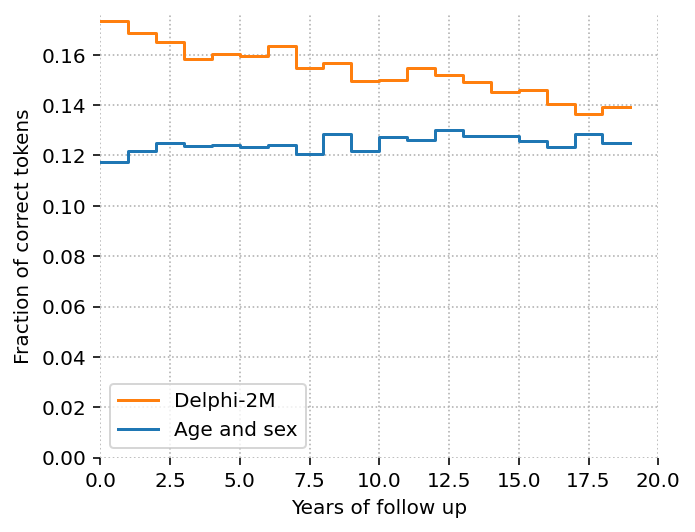

In [23]:
plt.figure(figsize=(5,4))

plt.plot([np.nanmean(n_sim_obs[:,n_obsyears==x].mean(0)/n_obs[n_obsyears==x].numpy())  for x in range(20)], label='Delphi-2M', ds='steps', c='C1')
plt.plot([np.nanmean(n_sim_obs_perm[:,n_obsyears==x].mean(0)/n_obs[n_obsyears==x].numpy())  for x in range(20)], label='Age and sex', ds='steps', c='C0')
plt.xlim(0,20)
plt.xlabel('Years of follow up')
plt.ylabel('Fraction of correct tokens')
plt.ylim(0,None)
plt.legend()